In [86]:
import nltk
from nltk.corpus import brown
import sklearn_crfsuite
from sklearn_crfsuite import CRF, metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import classification_report, confusion_matrix
import gradio as gr
import sentencepiece as spm
from nltk.tokenize import word_tokenize

In [87]:
nltk.download('brown')
nltk.download('universal_tagset')
nltk.download('punkt')

corpus = brown.tagged_sents(tagset='universal')

[nltk_data] Downloading package brown to
[nltk_data]     /Users/parthbatwara/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/parthbatwara/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/parthbatwara/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [88]:
# # Extract plain words (ignore tags)
# sentences = [[word.lower() for word, tag in sentence] for sentence in corpus]

# # Save the plain text sentences to a file
# with open("./brown_corpus.txt", "w") as f:
#     for sentence in sentences:
#         f.write(" ".join(sentence) + "\n")

# # Train a SentencePiece model (BPE model) with the prepared corpus
# spm.SentencePieceTrainer.train(input='./brown_corpus.txt', model_prefix='bpe', vocab_size=5000)

In [89]:
# Load the trained BPE model
sp = spm.SentencePieceProcessor(model_file='bpe.model')

def word2features(sent, i):
    word = sent[i][0]  # Get the word
    bpe_tokens = sp.encode(word, out_type=str)  # Break word into BPE tokens

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],  
        'word[-2:]': word[-2:],  
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'bpe_token_1': bpe_tokens[0],  # First BPE token
        'bpe_token_last': bpe_tokens[-1],  # Last BPE token
    }

    # Add subword length (useful for some models)
    features['bpe_length'] = len(bpe_tokens)

    # Handle previous word (-1) features
    if i > 0:
        word1 = sent[i-1][0]
        bpe_tokens_prev = sp.encode(word1, out_type=str)
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:bpe_token_1': bpe_tokens_prev[0],
            '-1:bpe_token_last': bpe_tokens_prev[-1],
        })
    else:
        features['BOS'] = True  # Beginning of sentence

    # Handle next word (+1) features
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        bpe_tokens_next = sp.encode(word1, out_type=str)
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:bpe_token_1': bpe_tokens_next[0],
            '+1:bpe_token_last': bpe_tokens_next[-1],
        })
    else:
        features['EOS'] = True  # End of sentence

    return features

In [90]:
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for (word, label) in sent]

def sent2tokens(sent):
    return [word for (word, label) in sent]

In [91]:
# Prepare data (use all sentences for cross-validation)
X = [sent2features(s) for s in corpus]
y = [sent2labels(s) for s in corpus]

In [92]:
# Initialize CRF model
crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

In [93]:
# Perform 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store metrics for each fold
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
f05_list = []
f2_list = []

# Extract the labels from the corpus (to get all POS tags)
all_labels = list(set([label for sent in y for label in sent]))

# Initialize per_tag_metrics using the labels found in the corpus
per_tag_metrics = {tag: {"precision": [], "recall": [], "f1": [], "f0.5": [], "f2": []} for tag in all_labels}

In [94]:
# Iterate through each fold
for train_index, test_index in kf.split(X):
    X_train, X_test = [X[i] for i in train_index], [X[i] for i in test_index]
    y_train, y_test = [y[i] for i in train_index], [y[i] for i in test_index]

    # Train CRF
    crf.fit(X_train, y_train)

    # Predict on test set
    y_pred = crf.predict(X_test)

    # Calculate metrics
    labels = list(crf.classes_)
    # Remove 'PUNCT' only if it exists in the labels
    if 'PUNCT' in labels:
        labels.remove('PUNCT')  # Remove punctuation for evaluation

    # Overall metrics
    accuracy = metrics.flat_accuracy_score(y_test, y_pred)
    report = metrics.flat_classification_report(y_test, y_pred, labels=labels, digits=3, output_dict=True)
    
    accuracy_list.append(accuracy)
    precision_list.append(report['weighted avg']['precision'])
    recall_list.append(report['weighted avg']['recall'])
    f1_list.append(report['weighted avg']['f1-score'])

    # Manually compute F0.5 and F2 for weighted averages
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']

    f05_score = (1 + 0.5**2) * (precision * recall) / ((0.5**2 * precision) + recall)
    f2_score = (1 + 2**2) * (precision * recall) / ((2**2 * precision) + recall)
    
    f05_list.append(f05_score)
    f2_list.append(f2_score)
    
    # Flatten y_test and y_pred for confusion matrix computation
    y_test_flat = [label for sublist in y_test for label in sublist]
    y_pred_flat = [label for sublist in y_pred for label in sublist]

    # Confusion matrix (optional, can store each fold's matrix)
    cm = confusion_matrix(y_test_flat, y_pred_flat, labels=labels)

    # Store per-POS metrics
    for label in labels:
        precision = report[label]['precision']
        recall = report[label]['recall']
        f1 = report[label]['f1-score']

        per_tag_metrics[label]['precision'].append(precision)
        per_tag_metrics[label]['recall'].append(recall)
        per_tag_metrics[label]['f1'].append(f1)
    

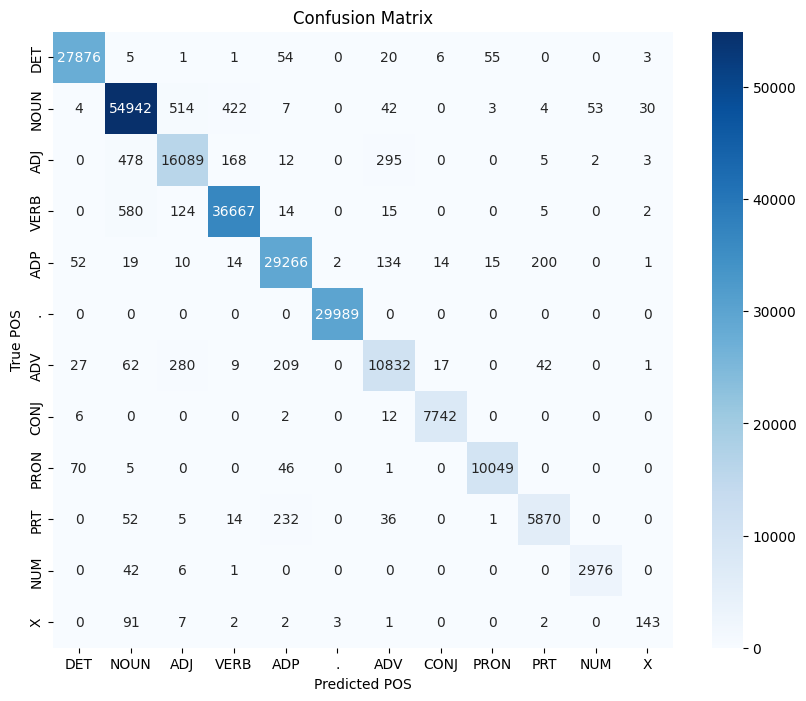

In [95]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True POS')
plt.xlabel('Predicted POS')
plt.show()

In [96]:
# Calculate average metrics across all folds
avg_accuracy = np.mean(accuracy_list)
avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)
avg_f1 = np.mean(f1_list)
avg_f05 = np.mean(f05_list)
avg_f2 = np.mean(f2_list)

# Print average cross-validation results
print("5-Fold Cross-Validation Results (CRF POS Tagger):")
print(f"Average Accuracy: {avg_accuracy:.6f}")
print(f"Average Precision: {avg_precision:.6f}")
print(f"Average Recall: {avg_recall:.6f}")
print(f"Average F1-score: {avg_f1:.6f}")
print(f"Average F0.5-score: {avg_f05:.6f}")
print(f"Average F2-score: {avg_f2:.6f}")

5-Fold Cross-Validation Results (CRF POS Tagger):
Average Accuracy: 0.979911
Average Precision: 0.979817
Average Recall: 0.979911
Average F1-score: 0.979800
Average F0.5-score: 0.979835
Average F2-score: 0.979892


In [97]:
# Calculate final per-tag metrics
final_per_tag_metrics = {}
for tag in per_tag_metrics:
    final_per_tag_metrics[tag] = {
        'precision': sum(per_tag_metrics[tag]['precision']) / len(per_tag_metrics[tag]['precision']),
        'recall': sum(per_tag_metrics[tag]['recall']) / len(per_tag_metrics[tag]['recall']),
        'f1': sum(per_tag_metrics[tag]['f1']) / len(per_tag_metrics[tag]['f1']),
    }

# Print per POS tag metrics
print("\nPer POS Tag Metrics:")
for tag, metrics in final_per_tag_metrics.items():
    print(f"\nPOS Tag: {tag}")
    print(f"Precision: {metrics['precision']:.3f}")
    print(f"Recall: {metrics['recall']:.3f}")
    print(f"F1-Score: {metrics['f1']:.3f}")


Per POS Tag Metrics:

POS Tag: ADJ
Precision: 0.945
Recall: 0.942
F1-Score: 0.943

POS Tag: NUM
Precision: 0.982
Recall: 0.983
F1-Score: 0.983

POS Tag: DET
Precision: 0.994
Recall: 0.995
F1-Score: 0.995

POS Tag: NOUN
Precision: 0.976
Recall: 0.981
F1-Score: 0.978

POS Tag: CONJ
Precision: 0.995
Recall: 0.997
F1-Score: 0.996

POS Tag: PRT
Precision: 0.955
Recall: 0.947
F1-Score: 0.951

POS Tag: ADP
Precision: 0.981
Recall: 0.985
F1-Score: 0.983

POS Tag: VERB
Precision: 0.982
Recall: 0.980
F1-Score: 0.981

POS Tag: ADV
Precision: 0.951
Recall: 0.940
F1-Score: 0.945

POS Tag: PRON
Precision: 0.993
Recall: 0.988
F1-Score: 0.990

POS Tag: .
Precision: 1.000
Recall: 1.000
F1-Score: 1.000

POS Tag: X
Precision: 0.810
Recall: 0.487
F1-Score: 0.603


In [101]:
import numpy as np


def print_confused_tags(cm, labels):

    cm_array = np.array(cm)

    print("\nConfused Tags:")
    for i, label in enumerate(labels):
        # Get the indices of the tags that were confused with the current tag
        confused_indices = np.argsort(cm_array[i])[::-1]  # Sort indices by descending order
        confused_tags = [(labels[j], cm_array[i][j]) for j in confused_indices if j != i]  # Exclude self
        
        # Print the top 3 most confused tags
        top_confusions = confused_tags[:1]  # Change the number if you want more/less
        if top_confusions:
            print(f"\nTag: {label}")
            for confused_tag, count in top_confusions:
                print(f"  Confused with '{confused_tag}' ({count})")

# Example usage
print_confused_tags(cm, labels)


Confused Tags:

Tag: DET
  Confused with 'PRON' (55)

Tag: NOUN
  Confused with 'ADJ' (514)

Tag: ADJ
  Confused with 'NOUN' (478)

Tag: VERB
  Confused with 'NOUN' (580)

Tag: ADP
  Confused with 'PRT' (200)

Tag: .
  Confused with 'X' (0)

Tag: ADV
  Confused with 'ADJ' (280)

Tag: CONJ
  Confused with 'ADV' (12)

Tag: PRON
  Confused with 'DET' (70)

Tag: PRT
  Confused with 'ADP' (232)

Tag: NUM
  Confused with 'NOUN' (42)

Tag: X
  Confused with 'NOUN' (91)


In [104]:
# Train on the full dataset
crf.fit(X, y)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    max_iterations=100)

In [111]:
# Function to tag a single sentence input using CRF
def tag_sentence(input_sentence):
    # Tokenize and convert the sentence into features
    words = nltk.word_tokenize(input_sentence)
    test_features = [word2features([(word, '')], 0) for word in words]
    
    # Predict tags for the sentence using the trained CRF model
    predicted_tags = crf.predict([test_features])[0]
    
    # Combine words and predicted tags
    tagged_sentence = [(word, tag) for word, tag in zip(words, predicted_tags)]
    
    return tagged_sentence

# Define a Gradio interface
def pos_tagger_interface(text):
    tagged = tag_sentence(text)
    # Format the tagged output for easier reading
    tagged_output = "\n".join([f"{word}: {tag}" for word, tag in tagged])
    return tagged_output

# Define input and output components
interface = gr.Interface(
    fn=pos_tagger_interface,  # The function to execute
    inputs=gr.Textbox(lines=2, placeholder="Enter a sentence..."),  # Textbox input
    outputs="text",  # The output is displayed as text
    title="CRF-based POS Tagger",
    description="Enter a sentence and get the predicted POS tags."
)

# Launch the Gradio interface
interface.launch()

Running on local URL:  http://127.0.0.1:7869

To create a public link, set `share=True` in `launch()`.


In [106]:
def sent2features_test(sent):
    return [word2features_test(sent, i) for i in range(len(sent))]

def word2features_test(sent, i):
    word, pos_tag = sent[i]  # Get the word and its POS tag

    bpe_tokens = sp.encode(word, out_type=str)  # Break word into BPE tokens

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],  
        'word[-2:]': word[-2:],  
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'bpe_token_1': bpe_tokens[0] if bpe_tokens else None,  # First BPE token
        'bpe_token_last': bpe_tokens[-1] if bpe_tokens else None,  # Last BPE token
    }

    # Add subword length (useful for some models)
    features['bpe_length'] = len(bpe_tokens) if bpe_tokens else 0

    # Handle previous word (-1) features
    if i > 0:
        word1, pos_tag1 = sent[i-1]
        bpe_tokens_prev = sp.encode(word1, out_type=str)
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:bpe_token_1': bpe_tokens_prev[0] if bpe_tokens_prev else None,
            '-1:bpe_token_last': bpe_tokens_prev[-1] if bpe_tokens_prev else None,
        })
    else:
        features['BOS'] = True  # Beginning of sentence

    # Handle next word (+1) features
    if i < len(sent) - 1:
        word1, pos_tag1 = sent[i + 1]
        bpe_tokens_next = sp.encode(word1, out_type=str)
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:bpe_token_1': bpe_tokens_next[0] if bpe_tokens_next else None,
            '+1:bpe_token_last': bpe_tokens_next[-1] if bpe_tokens_next else None,
        })
    else:
        features['EOS'] = True  # End of sentence

    return features


In [110]:
# List of sentences for testing
sentences = [
    # HMM is better
    "The cat sat.",
    "He runs every day.",
    "Birds fly south.",
    "They played soccer.",
    "Dogs bark at night.",
    "She sings beautifully.",
    "The sun shines bright.",
    "It is raining.",
    "The car is red.",
    "He ate lunch.",
    
    # CRF is better
    "The bank can refuse to lend.",
    "I watched her lead the team.",
    "He saw her duck.",
    "The old man the boat.",
    "She likes to cook.",
    "The novel is a great read.",
    "He left the room quietly.",
    "The chicken is on the table.",
    "The committee made a decision.",
    "She gave her friend a gift.",
    
    # Both are equal
    "They are going to the park.",
    "I love playing the guitar.",
    "She is reading a book.",
    "We enjoy hiking during the summer.",
    "He writes stories.",
    "The flowers bloom in spring.",
    "Cats and dogs are popular pets.",
    "The teacher explained the lesson.",
    "They danced all night.",
    "I finished my homework."
]
# Function to print POS tags for each sentence
def tag_sentence(input_sentence):
    # Tokenize and convert the sentence into features
    words = nltk.word_tokenize(input_sentence)
    test_features = [word2features([(word, '')], 0) for word in words]
    
    # Predict tags for the sentence using the trained CRF model
    predicted_tags = crf.predict([test_features])[0]
    
    # Combine words and predicted tags
    tagged_sentence = [(word, tag) for word, tag in zip(words, predicted_tags)]
    
    return tagged_sentence

# Define a Gradio interface
def print_pos_tags(sentences):
    for sentence in sentences:
        tagged = tag_sentence(sentence)
        # Format the tagged output for easier reading
        tagged_output = "\n".join([f"{word}: {tag}" for word, tag in tagged])
        print(tagged_output)
    print("")

# Print POS tags for all sentences
print_pos_tags(sentences)

The: DET
cat: NOUN
sat: VERB
.: .
He: PRON
runs: VERB
every: DET
day: NOUN
.: .
Birds: NOUN
fly: VERB
south: NOUN
.: .
They: PRON
played: VERB
soccer: NOUN
.: .
Dogs: NOUN
bark: NOUN
at: ADP
night: NOUN
.: .
She: PRON
sings: VERB
beautifully: ADV
.: .
The: DET
sun: NOUN
shines: VERB
bright: ADJ
.: .
It: PRON
is: VERB
raining: VERB
.: .
The: DET
car: NOUN
is: VERB
red: ADJ
.: .
He: PRON
ate: VERB
lunch: NOUN
.: .
The: DET
bank: NOUN
can: VERB
refuse: VERB
to: PRT
lend: VERB
.: .
I: PRON
watched: VERB
her: PRON
lead: VERB
the: DET
team: NOUN
.: .
He: PRON
saw: VERB
her: DET
duck: NOUN
.: .
The: DET
old: ADJ
man: NOUN
the: DET
boat: NOUN
.: .
She: PRON
likes: VERB
to: ADP
cook: NOUN
.: .
The: DET
novel: NOUN
is: VERB
a: DET
great: ADJ
read: VERB
.: .
He: PRON
left: VERB
the: DET
room: NOUN
quietly: ADV
.: .
The: DET
chicken: NOUN
is: VERB
on: ADP
the: DET
table: NOUN
.: .
The: DET
committee: NOUN
made: VERB
a: DET
decision: NOUN
.: .
She: PRON
gave: VERB
her: DET
friend: NOUN
a: DET
gift: